# DAGMC's CAD-Based Geometry in OpenMC

In [1]:
from IPython.display import Image
import openmc
import math
from matplotlib import pyplot as plt

## Warning

This notebook requires a version of OpenMC built with DAGMC geometry enabled. Use the following cell to determine whether or not this feature is enabled for the version of OpenMC being used here.

In [2]:
from warnings import warn
import openmc.lib

if not openmc.lib._dagmc_enabled():
    warn("DAGMC is not enabled.")

In [3]:
import urllib.request

fuel_pin_url = 'https://tinyurl.com/y3ugwz6w' # 1.2 MB
teapot_url = 'https://tinyurl.com/y4mcmc3u' # 29 MB
paramak_w_graveyard = 'https://tinyurl.com/y7w238th' # 18 MB

def download(url, filename="dagmc.h5m"):
    """
    Helper function for retrieving dagmc models
    """
    u = urllib.request.urlopen(url)
    
    if u.status != 200:
        raise RuntimeError("Failed to download file.")
    
    # save file as dagmc.h5m
    with open(filename, 'wb') as f:
        f.write(u.read())

To start, we'll be using a simple U235 fuel pin surrounded by a water moderator, so let's create those materials.

In [4]:
 # materials
u235 = openmc.Material(name="fuel")
u235.add_nuclide('U235', 1.0, 'ao')
u235.set_density('g/cc', 11)
u235.id = 40

water = openmc.Material(name="water")
water.add_nuclide('H1', 2.0, 'ao')
water.add_nuclide('O16', 1.0, 'ao')
water.set_density('g/cc', 1.0)
water.add_s_alpha_beta('c_H_in_H2O')
water.id = 41

materials = openmc.Materials([u235, water])

Now let's get our DAGMC geometry. We'll be using prefabricated models in this notebook. For information on how to create your own DAGMC models, you can refer to the instructions [here](https://svalinn.github.io/DAGMC/usersguide/trelis_workflow.html).

Let's download the DAGMC model. These models come in the form of triangle surface meshes stored using the the Mesh Oriented datABase ([MOAB](https://sigma.mcs.anl.gov/moab-library/)) in an HDF5 file with the extension `.h5m`. An example of a coarse triangle mesh looks like:

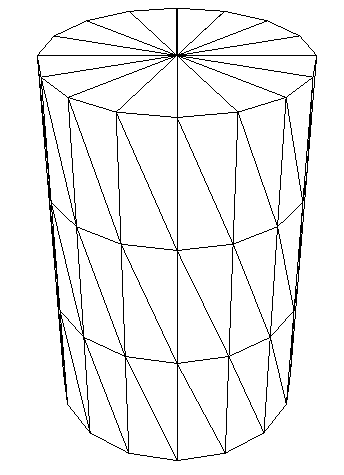

In [5]:
Image("./images/cylinder_mesh.png", width=350)

First we'll need to grab some pre-made DagMC models.

In [6]:
download(fuel_pin_url)

To create a geometry where DAGMC represents the entire model, we'll make a DAGMC universe and use it as the root universe of the model.

In [7]:
dagmc_univ = openmc.DAGMCUniverse(filename="dagmc.h5m")
geometry = openmc.Geometry(root=dagmc_univ)

Now we'll tie the geometry, materials and some settings into a model object.

In [8]:
settings = openmc.Settings()
settings.batches = 10
settings.inactive = 2
settings.particles = 5000

model = openmc.Model(geometry=geometry, materials=materials, settings=settings)
model.export_to_model_xml()

Unlike conventional geometries in OpenMC, we really have no way of knowing what our model looks like at this point. Thankfully DagMC geometries can be plotted just like any other OpenMC geometry to give us an idea of what we're now working with.

Note that material assignments have already been applied to this model. Materials can be assigned either using ids or names of materials in the `materials.xml` file. It is recommended that material names are used for assignment for readability.

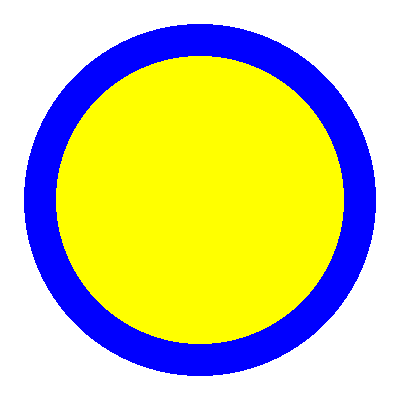

In [9]:
p = openmc.Plot()
p.width = (25.0, 25.0)
p.pixels = (400, 400)
p.color_by = 'material'
p.colors = {u235: 'yellow', water: 'blue'}
openmc.plot_inline(p)

Now that we've had a chance to examine the model a bit, we can finish applying our settings and add a source.

In [10]:
model.settings.source = openmc.Source(space=openmc.stats.Box([-4., -4., -4.],
                                                       [ 4.,  4.,  4.]))
model.export_to_model_xml()

Tallies work in the same way when using DAGMC geometries too. We'll add a tally on the fuel cell here.

In [11]:
tally = openmc.Tally()
tally.scores = ['total']
tally.filters = [openmc.CellFilter(1)]
tallies = openmc.Tallies([tally])

model.tallies = tallies
model.export_to_model_xml()

**Note:** Applying tally filters in DagMC models requires prior knowledge of the model. Here, we know that the fuel cell's volume ID in the CAD sofware is 1. To identify cells without use of CAD software, load them into the [OpenMC plotter](https://github.com/openmc-dev/plotter) where cell, material, and volume IDs can be identified for native both OpenMC and DagMC geometries.

Now we're ready to run the simulation just like any other OpenMC run.

In [12]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Neat! But this pincell is something we could've done with CSG. Let's take a look at something more complex. We'll download a pre-built model of the [Utah teapot](https://en.wikipedia.org/wiki/Utah_teapot) and use it here.

In [13]:
download(teapot_url, "teapot.h5m")
dagmc_univ = openmc.DAGMCUniverse(filename="teapot.h5m")
geometry = openmc.Geometry(root=dagmc_univ)

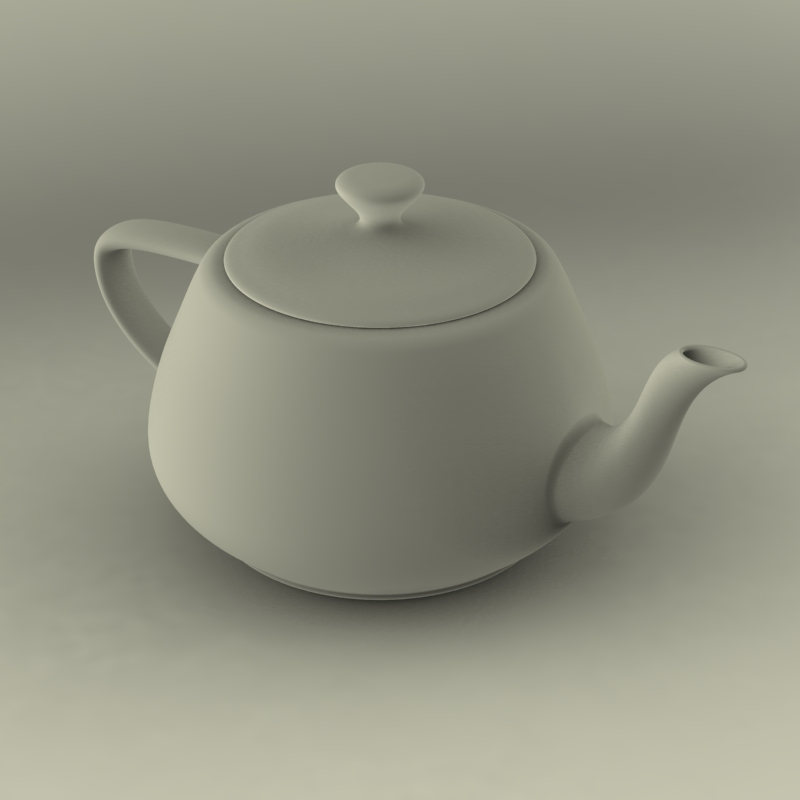

In [14]:
Image("./images/teapot.jpg", width=600)

Our teapot is made out of iron, so we'll want to create that material and make sure it is in our `materials.xml` file.

The DAGMC file contains tessellated surfaces that make up volumes. We can use built-in methods to inspect the geometry.

In [15]:
# returns the number of cells in the dagmc geometry
dagmc_univ.n_cells

5

In [16]:
# returns the number of surfaces in the dagmc geometry
dagmc_univ.n_surfaces

112

In [17]:
# returns the names of materials used in the geometry.
# these names are used when creating openmc.Materials
dagmc_univ.material_names

['Graveyard', 'iron', 'water']

In [18]:
iron = openmc.Material(name="iron")
iron.add_nuclide("Fe54", 0.0564555822608)
iron.add_nuclide("Fe56", 0.919015287728)
iron.add_nuclide("Fe57", 0.0216036861685)
iron.add_nuclide("Fe58", 0.00292544384231)
iron.set_density("g/cm3", 7.874)

water = openmc.Material(name="water")
water.add_nuclide('H1', 2.0, 'ao')
water.add_nuclide('O16', 1.0, 'ao')
water.set_density('g/cc', 1.0)
water.add_s_alpha_beta('c_H_in_H2O')
water.id = 41

materials = openmc.Materials([iron, water])

/home/pshriwise/soft/openmc/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=41.
  warn(msg, IDWarning)


In [19]:
settings = openmc.Settings()
settings.batches = 10
settings.particles = 5000
settings.run_mode = "fixed source"

space = openmc.stats.Box(*geometry.bounding_box)
my_source = openmc.Source(space=space, domains=[water])
my_source.energy = openmc.stats.Discrete(x=[12.0,], p=[1.0,])

settings.source = my_source

In [20]:
mesh = openmc.RegularMesh()  # could use from_domain here to avid setting lower_left and upper_right
mesh.dimension = (120, 1, 40)
mesh.lower_left = (-20.0, 0.0, -10.0)
mesh.upper_right = (20.0, 1.0, 4.0)

mesh_filter = openmc.MeshFilter(mesh)

pot_filter = openmc.CellFilter([1])
pot_tally = openmc.Tally()
pot_tally.filters = [mesh_filter, pot_filter]
pot_tally.scores = ['flux']

water_filter = openmc.CellFilter([5])
water_tally = openmc.Tally()
water_tally.filters = [mesh_filter, water_filter]
water_tally.scores = ['flux']


tallies = openmc.Tallies([pot_tally, water_tally])

In [21]:
model = openmc.Model(materials=materials, geometry=geometry, settings=settings, tallies=tallies)
model.export_to_model_xml()

To make sure we've updated the file correctly, let's make a plot of the teapot.

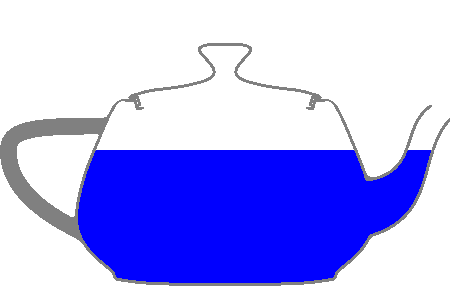

In [22]:
p = openmc.Plot()
p.basis = 'xz'
p.origin = (0.0, -0.1, 0.0)
p.width = (30.0, 20.0)
p.pixels = (450, 300)
p.color_by = 'material'
p.colors = {iron: 'gray', water: 'blue'}
openmc.plot_inline(p)

Here we start to see some of the advantages CAD geometries provide. This particular file was pulled from the [GrabCAD](https://grabcad.com/library) and pushed through the DAGMC workflow without modification (other than the addition of material assignments). It would take a considerable amount of time to create a model like this using CSG!

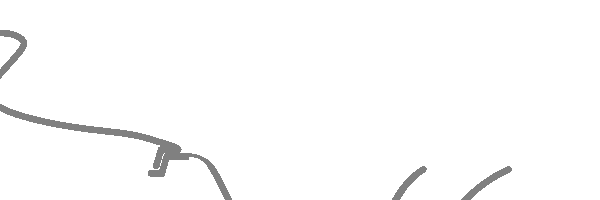

In [23]:
p.width = (18.0, 6.0)
p.basis = 'xz'
p.origin = (10.0, 0.1, 5.0)
p.pixels = (600, 200)
p.color_by = 'material'
openmc.plot_inline(p)

Now let's brew some tea! ... using a very hot neutron source. We'll use some well-placed point sources distributed throughout the model.

...and setup a couple of mesh tallies. One for the kettle, and one for the water inside.

In [24]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Note that the performance is significantly lower than our pincell model due to the increased complexity of the model, but it allows us to examine tally results like these:

In [25]:
sp = openmc.StatePoint("statepoint.10.h5")

water_tally = sp.get_tally(scores=['flux'], id=water_tally.id)
water_flux = water_tally.mean
water_flux.shape = (40, 120)
water_flux = water_flux[::-1, :]

pot_tally = sp.get_tally(scores=['flux'], id=pot_tally.id)
pot_flux = pot_tally.mean
pot_flux.shape = (40, 120)
pot_flux = pot_flux[::-1, :]

sp.close() # close the statepoint file to release HDF5 file handles

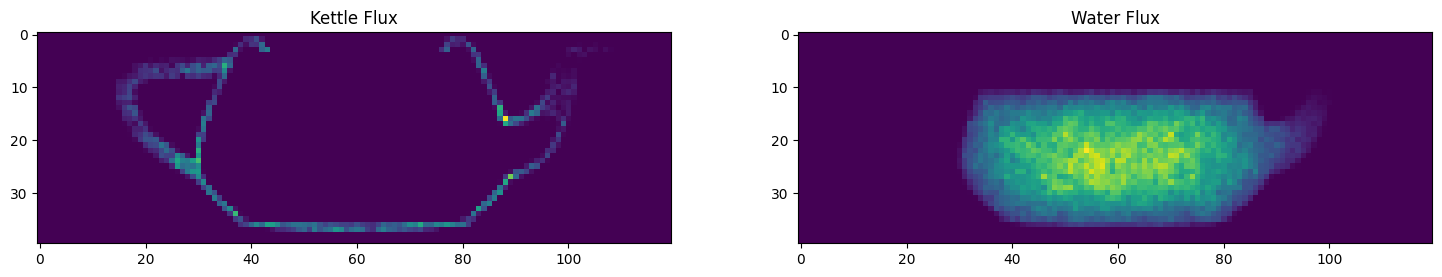

In [26]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(18, 16))

sub_plot1 = plt.subplot(121, title="Kettle Flux")
sub_plot1.imshow(pot_flux)

sub_plot2 = plt.subplot(122, title="Water Flux")
sub_plot2.imshow(water_flux)

# Tokamak Geometry

Next we'll look at a tokamak model courtesy of John Shimwell's [paramak](https://github.com/fusion-energy/paramak) package. With this model, we'll explore how to use CAD geometry as a universe in OpenMC to create repeating instances complex geometry or clip a CAD model to insert it into an OpenMC CSG geometry.

In [27]:
download(paramak_w_graveyard, 'paramak_with_graveyard.h5m')

First, we'll create some materials that we know are present in the paramak model. These will be assigned by the `Material.name` attribute to match those in the `paramak_with_graveyard.h5m` file.

In [28]:
materials = openmc.Materials()

mat_pf_coil_1 = openmc.Material(name="pf_coil_1")
mat_pf_coil_1.add_element("Cu", 1, "ao")
mat_pf_coil_1.set_density("g/cm3", 8.96)
materials.append(mat_pf_coil_1)

mat_pf_coil_2 = openmc.Material(name="pf_coil_2")
mat_pf_coil_2.add_element("Cu", 1, "ao")
mat_pf_coil_2.set_density("g/cm3", 8.96)
materials.append(mat_pf_coil_2)

mat_pf_coil_3 = openmc.Material(name="pf_coil_3")
mat_pf_coil_3.add_element("Cu", 1, "ao")
mat_pf_coil_3.set_density("g/cm3", 8.96)
materials.append(mat_pf_coil_3)

mat_pf_coil_4 = openmc.Material(name="pf_coil_4")
mat_pf_coil_4.add_element("Cu", 1, "ao")
mat_pf_coil_4.set_density("g/cm3", 8.96)
materials.append(mat_pf_coil_4)

mat_plasma = openmc.Material(name="plasma")
mat_plasma.add_element("H", 1, "ao")
mat_plasma.set_density("g/cm3", 0.00001)
materials.append(mat_plasma)

mat_inboard_tf_coils = openmc.Material(name="inboard_tf_coils")
mat_inboard_tf_coils.add_element("Cu", 1, "ao")
mat_inboard_tf_coils.set_density("g/cm3", 8.96)
materials.append(mat_inboard_tf_coils)

mat_center_column_shield = openmc.Material(name="center_column_shield")
mat_center_column_shield.add_element("W", 1, "ao")
mat_center_column_shield.set_density("g/cm3", 19.3)
materials.append(mat_center_column_shield)


mat_firstwall = openmc.Material(name="firstwall")
mat_firstwall.add_element("Fe", 1, "ao")
mat_firstwall.set_density("g/cm3", 7.7)
materials.append(mat_firstwall)

mat_blanket = openmc.Material(name="blanket")
mat_blanket.add_elements_from_formula("Pb842Li158")
mat_blanket.set_density("g/cm3", 19.)
materials.append(mat_blanket)

mat_blanket_rear_wall = openmc.Material(name="blanket_rear_wall")
mat_blanket_rear_wall.add_element("Fe", 1, "ao")
mat_blanket_rear_wall.set_density("g/cm3", 7.7)
materials.append(mat_blanket_rear_wall)

mat_divertor_upper = openmc.Material(name="divertor_upper")
mat_divertor_upper.add_element("W", 1, "ao")
mat_divertor_upper.set_density("g/cm3", 19.3)
materials.append(mat_divertor_upper)

mat_divertor_lower = openmc.Material(name="divertor_lower")
mat_divertor_lower.add_element("W", 1, "ao")
mat_divertor_lower.set_density("g/cm3", 19.3)
materials.append(mat_divertor_lower)

mat_pf_coil_case_1 = openmc.Material(name="pf_coil_case_1")
mat_pf_coil_case_1.add_element("Fe", 1, "ao")
mat_pf_coil_case_1.set_density("g/cm3", 8.96)
materials.append(mat_pf_coil_case_1)

mat_pf_coil_case_2 = openmc.Material(name="pf_coil_case_2")
mat_pf_coil_case_2.add_element("Fe", 1, "ao")
mat_pf_coil_case_2.set_density("g/cm3", 8.96)
materials.append(mat_pf_coil_case_2)

mat_pf_coil_case_3 = openmc.Material(name="pf_coil_case_3")
mat_pf_coil_case_3.add_element("Fe", 1, "ao")
mat_pf_coil_case_3.set_density("g/cm3", 8.96)
materials.append(mat_pf_coil_case_3)

mat_pf_coil_case_4 = openmc.Material(name="pf_coil_case_4")
mat_pf_coil_case_4.add_element("Fe", 1, "ao")
mat_pf_coil_case_4.set_density("g/cm3", 8.96)
materials.append(mat_pf_coil_case_4)

Next, we'll create a ring source to mock a fusion neutron source in the middle of the tokamak.

In [29]:
# creates a simple isotropic neutron source in the center with 14MeV neutrons
source = openmc.Source()
# the distribution of radius is just a single value at the plasma major radius
radius = openmc.stats.Discrete([250.], [1])
# the distribution of source z values is just a single value
z_values = openmc.stats.Discrete([0], [1])
# the distribution of source azimuthal angles values is a uniform distribution between 0 and 0.5 Pi
# these angles must be the same as the reflective angles
angle = openmc.stats.Uniform(a=0., b=math.radians(180))
# this makes the ring source using the three distributions and a radius
source.space = openmc.stats.CylindricalIndependent(r=radius, phi=angle, z=z_values, origin=(0.0, 0.0, 0.0))
# sets the direction to isotropic
source.angle = openmc.stats.Isotropic()
# sets the energy distribution to a Muir distribution of D-T fusion neutrons
source.energy = openmc.stats.Muir(e0=14_000_000.0, m_rat=5.0, kt=20000.0)

/home/pshriwise/soft/openmc/openmc/stats/univariate.py:757: FutureWarning: The Muir(...) class has been replaced by the muir(...) function and will be removed in a future version of OpenMC. Use muir(...) instead.
  warn(


Now we'll create a CAD-based DAGMC universe containing the paramak model.

In [30]:
dag_universe = openmc.DAGMCUniverse('paramak_with_graveyard.h5m')
geometry = openmc.Geometry(root=dag_universe)

And we'll apply a flux tally using a mesh over the entire model that tallies flux results only in the blanket region (shown in . Access to information about DAGMC models from the Python API is limited to information like the global bounding box of the model, which is enough to use the `RegularMesh.from_domain` method to automatically create a mesh that covers the model.

In [31]:
mesh = openmc.RegularMesh.from_domain(geometry, dimension=(100,100,100))

mesh_filter = openmc.MeshFilter(mesh)

material_filter = openmc.MaterialFilter([mat_blanket])

flux_tally = openmc.Tally(name='blanket flux')
flux_tally.filters = [mesh_filter, material_filter]
flux_tally.scores = ['flux']

We'll now tie the materials, geometry, tallies, and settings together in a model class and plot the model. Below is an X-Z slice plot of this model colored by material.

In [32]:
model = openmc.Model()
model.geometry = geometry
model.materials = materials
model.tallies = [flux_tally]
model.settings.run_mode = 'fixed source'
model.settings.source = source
model.settings.batches = 10
model.settings.particles = 10000

In [33]:
model.export_to_model_xml()

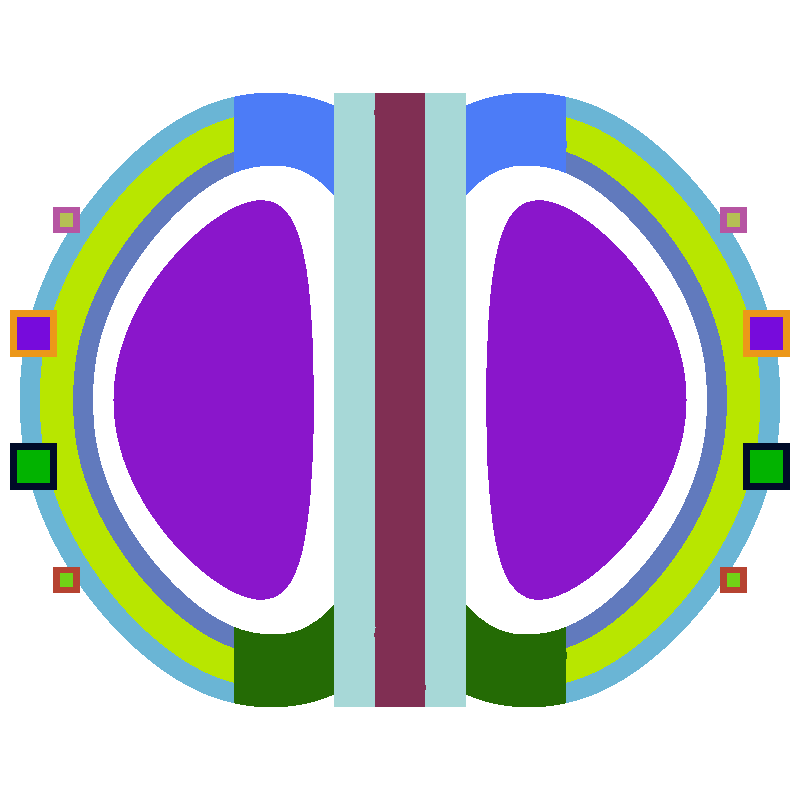

In [34]:
p = openmc.Plot()
p.origin = (0, 10, 0)
p.pixels = (800, 800)
p.width = (1200, 1200)
p.basis = 'xz'
p.color_by = 'material'
openmc.plot_inline([p])

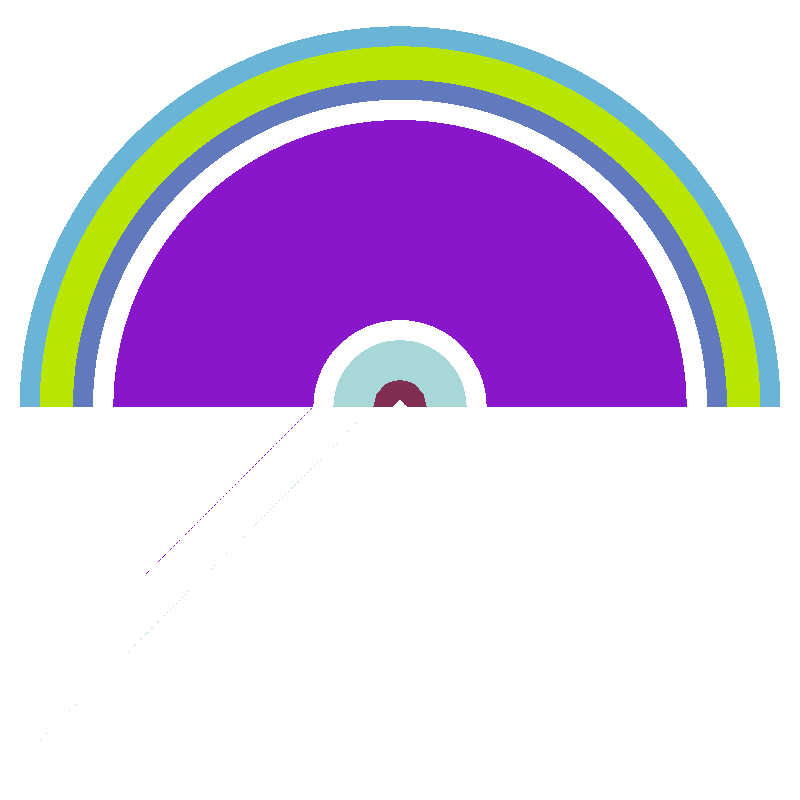

In [35]:
p.basis = 'xy'
openmc.plot_inline(p)

Time to run a full simulation so we can view the results.

In [36]:
sp_filename = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

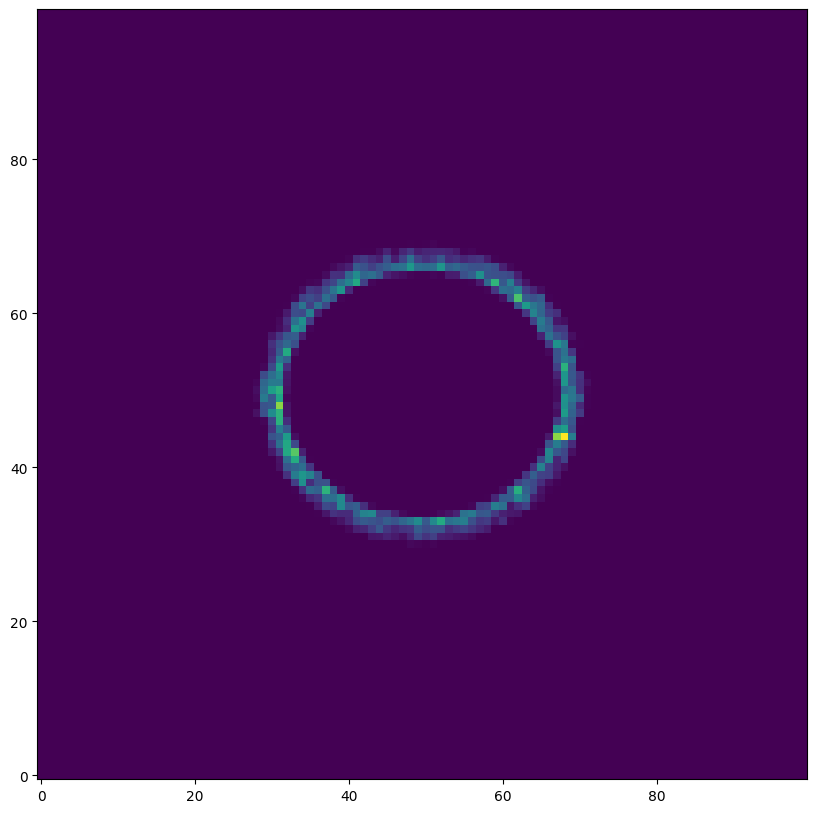

In [37]:
with openmc.StatePoint(sp_filename) as sp:
    flux_tally = sp.get_tally(name='blanket flux')

flux_mean = flux_tally.mean.reshape(*mesh.dimension)
plt.figure(figsize=(10,10))
plt.imshow(flux_mean[:, 50, :], origin='lower')

Let's change this tokamak model from a 180 section to a 90 degree section by creating a CSG box and filling it with the DAGMC universe.

In [38]:
x_min = openmc.XPlane(0.0, boundary_type='reflective')
x_max = openmc.XPlane(600.0, boundary_type='vacuum')

y_min = openmc.YPlane(0.0, boundary_type='reflective')
y_max = openmc.YPlane(600.0, boundary_type='vacuum')

region = +x_min & -x_max & +y_min & -y_max
quarter_cell = openmc.Cell(fill=dag_universe, region=region)
dag_universe.auto_geom_ids = True

model.geometry = openmc.Geometry([quarter_cell])
model.export_to_model_xml()

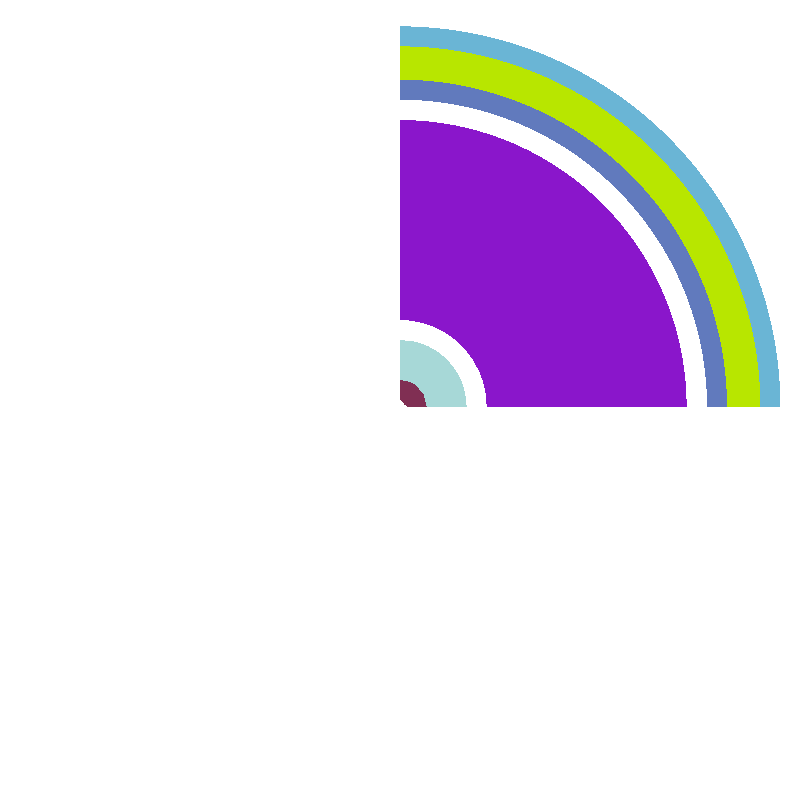

In [39]:
p.basis = 'xy'
openmc.plot_inline(p)

Any of the geometry modification options for the CSG cell apply just as they would for a geometry with CAD parts. We can just as easily take this one-quarter symmetric section and turn it into a one-eigth symmetric section by adding a Z plane to the cell.

In [40]:
z_min = openmc.ZPlane(-0.1, boundary_type='reflective')
quarter_cell.region &= +z_min

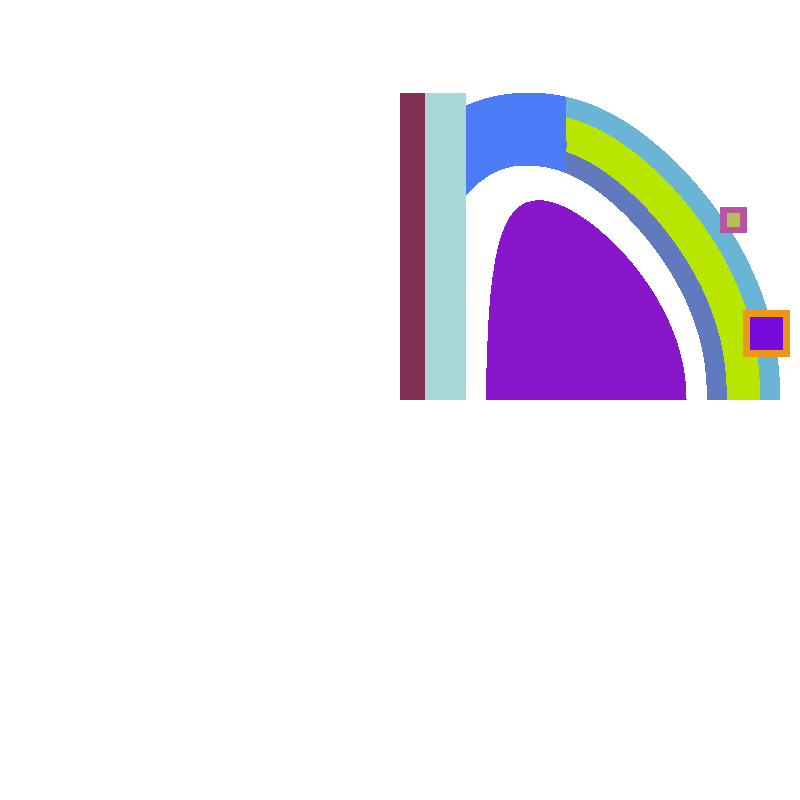

In [41]:
model.export_to_model_xml()
p.basis = 'xz'
openmc.plot_inline(p)

We'll create a new tally that only covers this region of the geometry; and, same as before, we'll tally a flux in the blanket region.

In [42]:
mesh = openmc.RegularMesh()
mesh.lower_left = [0.0,  0.0, 0.0]
mesh.upper_right = [500, 500, 500]
mesh.dimension = (200, 200, 200)

mesh_filter = openmc.MeshFilter(mesh)

material_filter = openmc.MaterialFilter([mat_blanket])

flux_tally = openmc.Tally(name='blanket flux')
flux_tally.filters = [mesh_filter, material_filter]
flux_tally.scores = ['flux']

model.tallies = [flux_tally]

In [43]:
model.export_to_model_xml()
sp_filename = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

When veiwing a X-Z slice of this image at the correct depth, we can see the rectangular coil regions clipped out of the mesh due to the combination of filters applied.

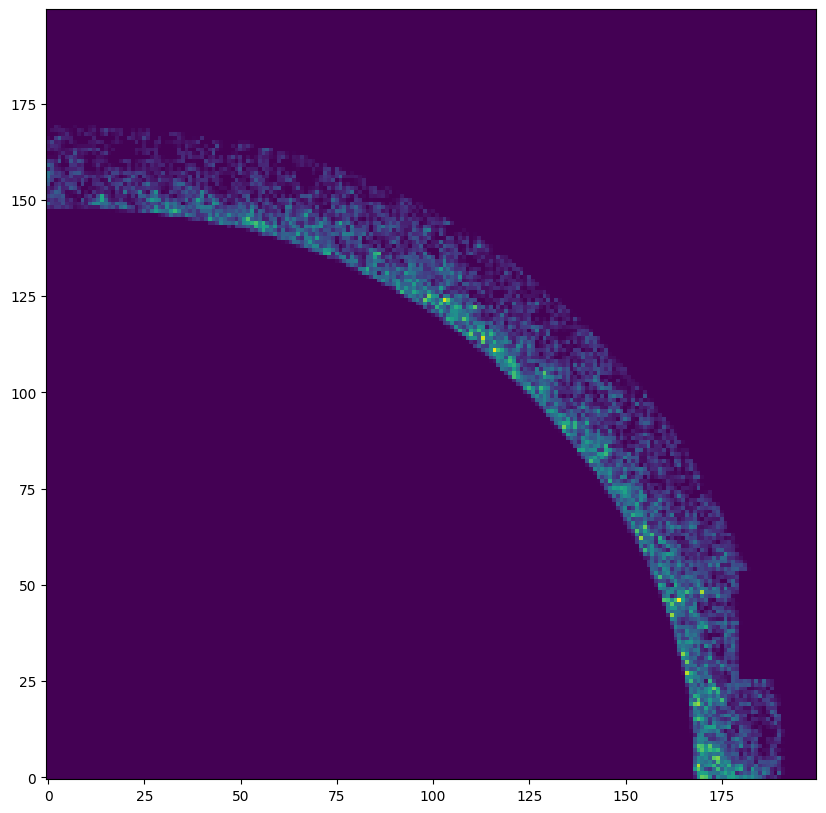

In [44]:
with openmc.StatePoint(sp_filename) as sp:
    flux_tally = sp.get_tally(name='blanket flux')

flux_mean = flux_tally.mean.reshape(*mesh.dimension)
plt.figure(figsize=(10,10))
plt.imshow(flux_mean[:, 100, :], origin='lower')

Now we'll replicate this DAGMC unvierse and create a full 360 degree model. We can do this by creating two cells, one for each half of the tokamak. We then fill each cell with the DAGMC universe and rotate the universe inside the cell on the negative side of the Y=0 plane to complete the model.

In [45]:
x_min = openmc.XPlane(-650.0, boundary_type='vacuum')
x_max = openmc.XPlane(650.0, boundary_type='vacuum')

y_min = openmc.YPlane(-650.0, boundary_type='vacuum')
y_max = openmc.YPlane(650.0, boundary_type='vacuum')

z_min = openmc.ZPlane(-650.0, boundary_type='vacuum')
z_max = openmc.ZPlane(650.0, boundary_type='vacuum')

y0 = openmc.YPlane(0.0)

c_upper = openmc.Cell(fill=dag_universe, region=+x_min & -x_max & +y0 & -y_max & +z_min & -z_max)
c_lower = openmc.Cell(fill=dag_universe, region=+x_min & -x_max & +y_min & -y0 & +z_min & -z_max)
c_lower.rotation = (0.0, 0.0, 180.0) # this rotation applies to the contents of the cell

dag_universe.auto_geom_ids = True
geometry = openmc.Geometry([c_upper, c_lower])
model.geometry = geometry

We'll plot the model one more time to convince ourselves that it's worked.

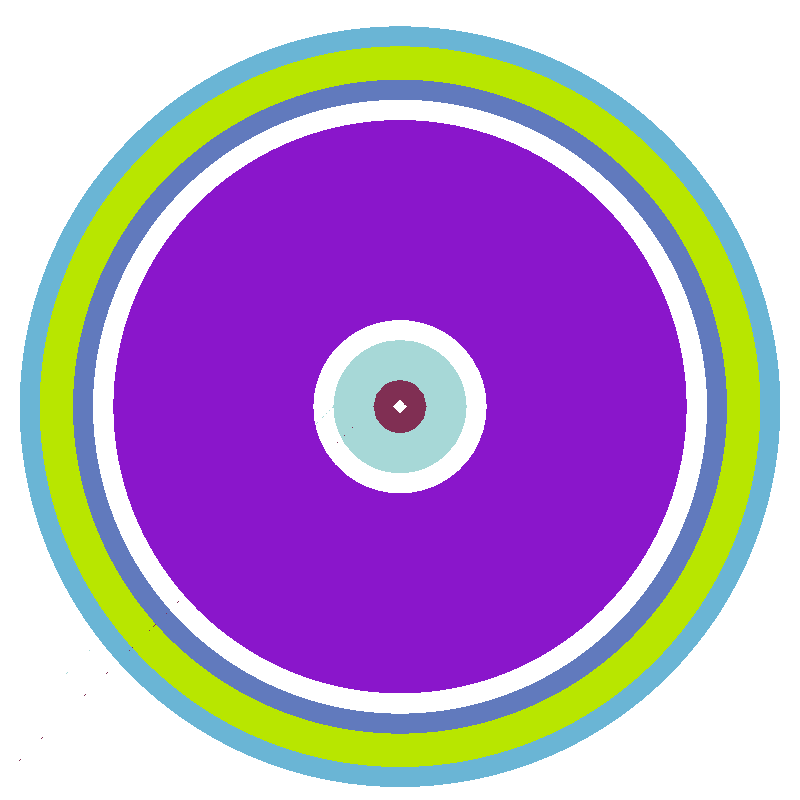

In [46]:
model.export_to_model_xml()
p.basis = 'xy'
openmc.plot_inline(p)

In [47]:
sp_filename = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################